In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Kayree\AppData\Local\Temp\ipykernel_5832\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
session.query(func.max(Measurement.date)).all()

[('2017-08-23',)]

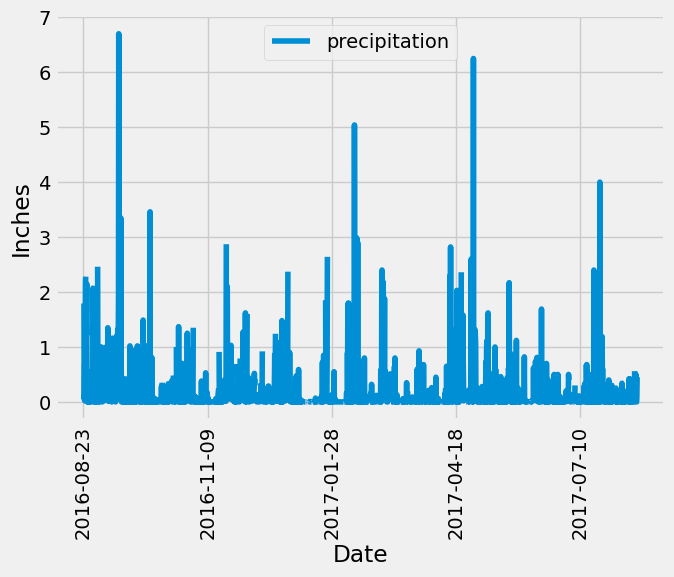

<Figure size 640x480 with 0 Axes>

In [76]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = session.query(func.max(Measurement.date)).all()[0][0]

most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

one_year_ago = most_recent_date - dt.timedelta(days=366) #Accounting for the leap year

# Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date > one_year_ago)  
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.set_index('Date', inplace=True)
precipitation_df.plot(rot=90, figsize=(7, 5))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()
plt.savefig('precipitation.png')

In [55]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary.to_frame(name='precipitation')


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [57]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [61]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [65]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
most_active_station_data = session.query(*temp_stats).filter(Measurement.station == session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]).first()
most_active_station_data


(54.0, 85.0, 71.66378066378067)

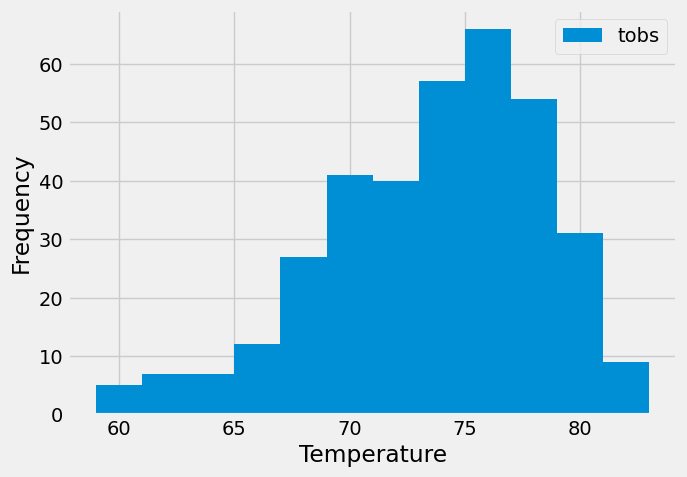

<Figure size 640x480 with 0 Axes>

In [77]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Step 1: Find the most active station ID
most_active_station_id = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]

# Step 2: Calculate the date one year ago from the most recent date
most_recent_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station_id).first()[0]
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Step 3: Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Step 4: Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

# Step 5: Plot the results as a histogram
temperature_df.plot.hist(bins=12, figsize=(7, 5))
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()
plt.savefig('temperature.png')



# Close Session

In [75]:
# Close Session
session.close()